# Loop Hydrodynamic Simulations Example
In this notebook, we'll create a simulated active region, along with the loop components, and then simulate the evolution of these loops using EBTEL.

In [23]:
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from sunpy.net import vso

import synthesizAR
from synthesizAR.model_ext import UniformHeating
from synthesizAR.model_ext import EbtelInterface 

%matplotlib inline

## Magnetic Skeleton
Query an HMI magnetogram, extrapolate the field, and trace the fieldlines.

First, get the HMI data.

In [ ]:
#VSO not returning anything for some reason...
client = vso.VSOClient()
result_hmi = client.query(
     vso.attrs.Time((2013, 1, 1, 7, 34, 0), (2013, 1, 1, 9, 0, 0)),
     vso.attrs.Instrument('HMI'),
     vso.attrs.Physobs('LOS_magnetic_field'),   # Physical observables
     vso.attrs.Sample(5000 * u.s)
)
data_hmi = client.get(result_hmi,methods=('URL-FILE_Rice','URL-FILE')).wait()

In [2]:
data_hmi = ['/Users/willbarnes/sunpy/data/hmi_m_45s_2013_01_01_07_35_15_tai_magnetogram.0.fits']

Resample and crop the observation,

In [3]:
crop = (u.Quantity([-140,90]*u.arcsec),u.Quantity([420,560]*u.arcsec))
resample = u.Quantity([20,20]*u.pixel)

Create the skeleton,

In [4]:
field = synthesizAR.Skeleton(data_hmi[0],crop=crop,resample=resample)
zshape=20
zrange=u.Quantity([0.,150.]*u.arcsec)
field.extrapolate_field(zshape,zrange)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:130: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


True


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/numba/decorators.py:24: DeprecationWarning: autojit is deprecated, use jit instead which now performs the same functionality
  "the same functionality", DeprecationWarning)
yt : [INFO     ] 2016-10-10 14:09:30,475 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-10-10 14:09:30,479 Parameters: domain_dimensions         = [16 16 16]
yt : [INFO     ] 2016-10-10 14:09:30,483 Parameters: domain_left_edge          = [ -8.29528770e+09   3.08229957e+10   1.06487377e+09]
yt : [INFO     ] 2016-10-10 14:09:30,487 Parameters: domain_right_edge         = [  4.76307298e+09   3.87553771e+10   9.58386396e+09]
yt : [INFO     ] 2016-10-10 14:09:30,491 Parameters: cosmological_simulation   = 0.0


Trace the fieldlines,

In [5]:
field.extract_streamlines(200)

yt : [INFO     ] 2016-10-10 14:09:32,115 AMRKDTree rebuilt, Final Volume: 8.824302e+29
Streamlining: 100%|██████████| 200/200 [00:00<00:00, 534.06it/s]
yt : [INFO     ] 2016-10-10 14:09:32,910 AMRKDTree rebuilt, Final Volume: 8.824302e+29
Streamlining: 100%|██████████| 101/101 [00:00<00:00, 594.74it/s]
yt : [INFO     ] 2016-10-10 14:09:33,351 AMRKDTree rebuilt, Final Volume: 8.824302e+29
Streamlining: 100%|██████████| 49/49 [00:00<00:00, 410.74it/s]
yt : [INFO     ] 2016-10-10 14:09:33,741 AMRKDTree rebuilt, Final Volume: 8.824302e+29
Streamlining: 100%|██████████| 24/24 [00:00<00:00, 422.16it/s]
yt : [INFO     ] 2016-10-10 14:09:33,996 AMRKDTree rebuilt, Final Volume: 8.824302e+29
Streamlining: 100%|██████████| 10/10 [00:00<00:00, 484.12it/s]
yt : [INFO     ] 2016-10-10 14:09:34,185 AMRKDTree rebuilt, Final Volume: 8.824302e+29
Streamlining: 100%|██████████| 6/6 [00:00<00:00, 324.83it/s]
yt : [INFO     ] 2016-10-10 14:09:34,387 AMRKDTree rebuilt, Final Volume: 8.824302e+29
Streamlinin

Take a quick look at the extrapolated field.

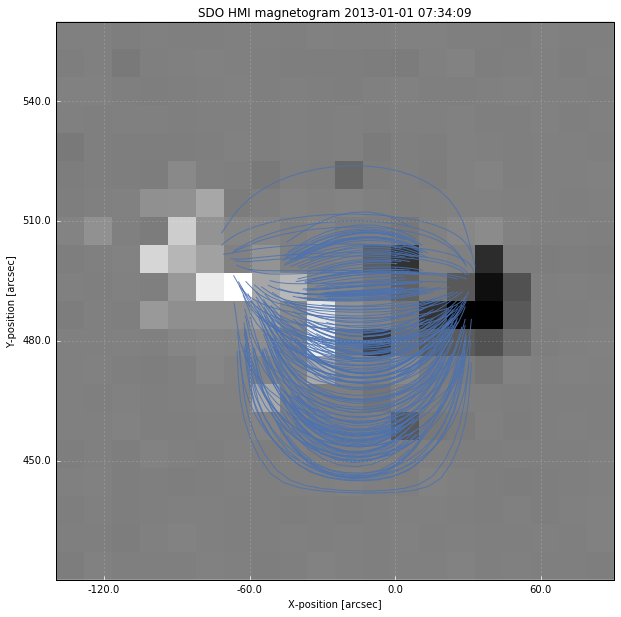

In [6]:
field.peek(alpha=0.85)

## Loops
Now, we'll use the individual streamlines as loops and compute the evolution of each with EBTEL. We can make 200 loop objects out of the streamlines by using,

In [7]:
field.make_loops()

Now, we want to configure an EBTEL run for each of these loop objects. But how will these loops be heated? To specify this, we configure a heating model object.

In [8]:
heating_options = {
    'duration':200.0,
    'duration_rise':50.0,
    'duration_decay':100.0,
    'average_waiting_time':1000.0,
    'stress_level':0.3
}
uni_model = UniformHeating(heating_options)

Now, load in a base dictionary (from the included example ebtel++ config file) for setting up all of the EBTEL parameters. When configuring the AR loops, we'll only need to alter a few parameters.

In [9]:
ih = synthesizAR.util.InputHandler(os.path.join(os.environ['EXP_DIR'],'ebtelPlusPlus/config/ebtel.example.cfg.xml'))

In [10]:
base_config = ih.lookup_vars()

In [11]:
base_config['use_adaptive_solver'] = True
base_config['rka_error'] = 1e-8
base_config['total_time'] = 15000.0

Next, instantiate the EBTEL interface for loading and configuring EBTEL input and output from and to the field object.

In [12]:
ebtel_plug = EbtelInterface(base_config,uni_model)

Finally, hand the EBTEL interface to the field and create the configuration files.

In [13]:
field.configure_loop_simulations(ebtel_plug,parent_config_dir='/Users/willbarnes/Desktop/synth_ebtel_test/config/',
                                 parent_results_dir='/Users/willbarnes/Desktop/synth_ebtel_test/results')

And run the simulations,

In [19]:
for loop in field.loops:
    subprocess.call([os.path.join(os.environ['EXP_DIR'],'ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

And load the temperature and density profiles back into the loop.

In [20]:
field.load_loop_simulations(ebtel_plug)